In [22]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from random import sample
from numpy.random import uniform
from matplotlib import pyplot as plt


In [6]:
from typing import Union

import numpy as np
import pandas as pd
from sklearn.neighbors import BallTree


def hopkins(data_frame: Union[np.ndarray, pd.DataFrame], sampling_size: int) -> float:
    """Assess the clusterability of a dataset. A score between 0 and 1, a score around 0.5 express
    no clusterability and a score tending to 0 express a high cluster tendency.
    Examples
    --------
    >>> from sklearn import datasets
    >>> from pyclustertend import hopkins
    >>> X = datasets.load_iris().data
    >>> hopkins(X,150)
    0.16
    """

    if type(data_frame) == np.ndarray:
        data_frame = pd.DataFrame(data_frame)

    data_frame_sample = sample_observation_from_dataset(data_frame, sampling_size)

    sample_distances_to_nearest_neighbours = get_distance_sample_to_nearest_neighbours(
        data_frame, data_frame_sample
    )

    uniformly_selected_observations_df = simulate_df_with_same_variation(
        data_frame, sampling_size
    )

    df_distances_to_nearest_neighbours = get_nearest_sample(
        data_frame, uniformly_selected_observations_df
    )

    x = sum(sample_distances_to_nearest_neighbours)
    y = sum(df_distances_to_nearest_neighbours)

    if x + y == 0:
        raise Exception("The denominator of the hopkins statistics is null")

    return x / (x + y)[0]


def get_nearest_sample(df: pd.DataFrame, uniformly_selected_observations: pd.DataFrame):
    tree = BallTree(df, leaf_size=2)
    dist, _ = tree.query(uniformly_selected_observations, k=1)
    uniformly_df_distances_to_nearest_neighbours = dist
    return uniformly_df_distances_to_nearest_neighbours


def simulate_df_with_same_variation(
    df: pd.DataFrame, sampling_size: int
) -> pd.DataFrame:
    max_data_frame = df.max()
    min_data_frame = df.min()
    uniformly_selected_values_0 = np.random.uniform(
        min_data_frame[0], max_data_frame[0], sampling_size
    )
    uniformly_selected_values_1 = np.random.uniform(
        min_data_frame[1], max_data_frame[1], sampling_size
    )
    uniformly_selected_observations = np.column_stack(
        (uniformly_selected_values_0, uniformly_selected_values_1)
    )
    if len(max_data_frame) >= 2:
        for i in range(2, len(max_data_frame)):
            uniformly_selected_values_i = np.random.uniform(
                min_data_frame[i], max_data_frame[i], sampling_size
            )
            to_stack = (uniformly_selected_observations, uniformly_selected_values_i)
            uniformly_selected_observations = np.column_stack(to_stack)
    uniformly_selected_observations_df = pd.DataFrame(uniformly_selected_observations)
    return uniformly_selected_observations_df


def get_distance_sample_to_nearest_neighbours(df: pd.DataFrame, data_frame_sample):
    tree = BallTree(df, leaf_size=2)
    dist, _ = tree.query(data_frame_sample, k=2)
    data_frame_sample_distances_to_nearest_neighbours = dist[:, 1]
    return data_frame_sample_distances_to_nearest_neighbours


def sample_observation_from_dataset(df, sampling_size: int):
    if sampling_size > df.shape[0]:
        raise Exception("The number of sample of sample is bigger than the shape of D")
    data_frame_sample = df.sample(n=sampling_size)
    return data_frame_sample

In [7]:
def hopkins_statistic(X):
    sample_size = int(X.shape[0]*0.05) #0.05 (5%) based on paper by Lawson and Jures
    
    
    #a uniform random sample in the original data space
    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0) ,(sample_size , X.shape[1]))
    
    
    
    #a random sample of size sample_size from the original data X
    random_indices=sample(range(0, X.shape[0], 1), sample_size)
    X_sample = X[random_indices]
   
    
    #initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs=neigh.fit(X)
    
    #u_distances = nearest neighbour distances from uniform random sample
    u_distances , u_indices = nbrs.kneighbors(X_uniform_random_sample , n_neighbors=2)
    u_distances = u_distances[: , 0] #distance to the first (nearest) neighbour
    
    #w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances , w_indices = nbrs.kneighbors(X_sample , n_neighbors=2)
    #distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[: , 1]
    
 
    
    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)
    
    #compute and return hopkins' statistic
    H = u_sum/ (u_sum + w_sum)
    return H
    

In [8]:
embeddings = pd.read_pickle("../data/processed/graph_data.pkl")

In [9]:
X = np.array(embeddings.graph_embedding.to_list())

In [10]:
h_stat = hopkins_statistic(X)
h_stat

0.978028397603556

In [11]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan

In [12]:
clust = OPTICS(min_samples=20)
clust.fit(X)

C:\Users\ethan\anaconda3\lib\site-packages\sklearn\cluster\_optics.py:804: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


OPTICS(min_samples=20)

In [13]:
from sklearn.preprocessing import scale

In [14]:
test = hopkins(scale(X), X.shape[0])

In [15]:
test

0.024933664122019233

In [16]:
import hdbscan
from sklearn import metrics

In [17]:
h = hdbscan.HDBSCAN(min_cluster_size=37, metric='manhattan')
h.fit(X)
metrics.silhouette_score(X, h.labels_, metric='manhattan')

-0.1621744034748126

In [18]:
s = pd.Series(h.labels_)
s.value_counts()

-1    576
 0    100
 1     84
dtype: int64

## Visualizing principal components

In [19]:
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

In [38]:
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X)

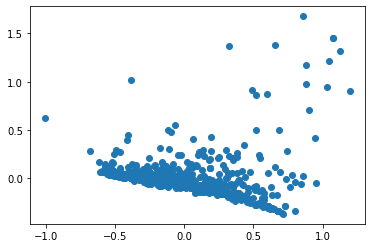

In [39]:
plt.scatter(x=pca_2d[:, 0], y=pca_2d[:, 1])